In [29]:
import warnings
warnings.filterwarnings('ignore')

import os
import pandas as pd
from datetime import timedelta

os.environ['ZIPLINE_ROOT'] = os.path.join(os.getcwd(), '~\.zipline')
os.listdir(os.environ['ZIPLINE_ROOT'])

os.environ['ZIPLINE_TRADER_CONFIG'] = os.path.join(os.getcwd(), "./zipline-trader.yaml")
with open(os.environ['ZIPLINE_TRADER_CONFIG'], 'r') as f:
    data = f.read()
    print(data[:20])
import zipline
from zipline.data import bundles

from zipline.utils.calendars import get_calendar
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.factors import CustomFactor
from zipline.research.utils import get_pricing, create_data_portal, create_pipeline_engine

# Set the trading calendar
trading_calendar = get_calendar('NYSE')
bundle_name = 'alpaca_api'
start_date = pd.Timestamp('2020-12-31', tz='utc')
pipeline_start_date = start_date 
end_date = pd.Timestamp('2021-02-26', tz='utc')
data_portal = create_data_portal(bundle_name, trading_calendar, start_date)

alpaca:
  key_id: "P


In [30]:
engine = create_pipeline_engine(bundle_name)
from zipline.pipeline.factors import CustomFactor, Returns
from zipline.pipeline.data import USEquityPricing

In [31]:
class YearlyReturns(CustomFactor):
    inputs = [USEquityPricing.close]
    window_length = 30
    def compute(self, today, assets, out, prices):
        start = self.window_length
        out[:] = (prices[-1] - prices[-start])/prices[-start]



In [32]:
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.factors import AverageDollarVolume
from zipline.pipeline import Pipeline
from zipline.pipeline.classifiers.custom.sector import ZiplineTraderSector, SECTOR_LABELS

universe = USEquityPricing
universe = AverageDollarVolume(window_length = 5)

pipeline = Pipeline(
    columns = {
            'MyFactor' : YearlyReturns(),
#             'Returns': Returns(window_length=252),  # same as YearlyRetruns
            'Sector' : ZiplineTraderSector()
    }, domain=US_EQUITIES
)

In [34]:
# Run our pipeline for the given start and end dates
factors = engine.run_pipeline(pipeline, pipeline_start_date, end_date)


In [36]:
asset_list = factors.index.levels[1].unique()

prices = get_pricing(
        data_portal,
        trading_calendar,
        asset_list,
        pipeline_start_date,
        end_date)

In [40]:
import alphalens as al 
factor_data = al.utils.get_clean_factor_and_forward_returns(
        factor=factors["MyFactor"],
        prices=prices,
        quantiles=5,
        periods=[1, 5, 10],
        groupby=factors["Sector"],
        binning_by_group=True,
        groupby_labels=SECTOR_LABELS,
    max_loss=0.8)


Dropped 52.1% entries from factor data: 28.2% in forward returns computation and 23.9% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 80.0%, not exceeded: OK!


Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1.0,-0.049736,0.076373,0.019315,0.035191,28,50.0
5.0,0.033594,0.211998,0.121039,0.053920,28,50.0


Returns Analysis


,1D,5D,10D
Ann. alpha,-0.025,-0.008,0.128
beta,0.161,-0.062,-0.382
Mean Period Wise Return Top Quantile (bps),6.366,-2.694,-7.112
Mean Period Wise Return Bottom Quantile (bps),-6.366,2.692,7.067
Mean Period Wise Spread (bps),12.731,-5.417,-14.214


<Figure size 432x288 with 0 Axes>

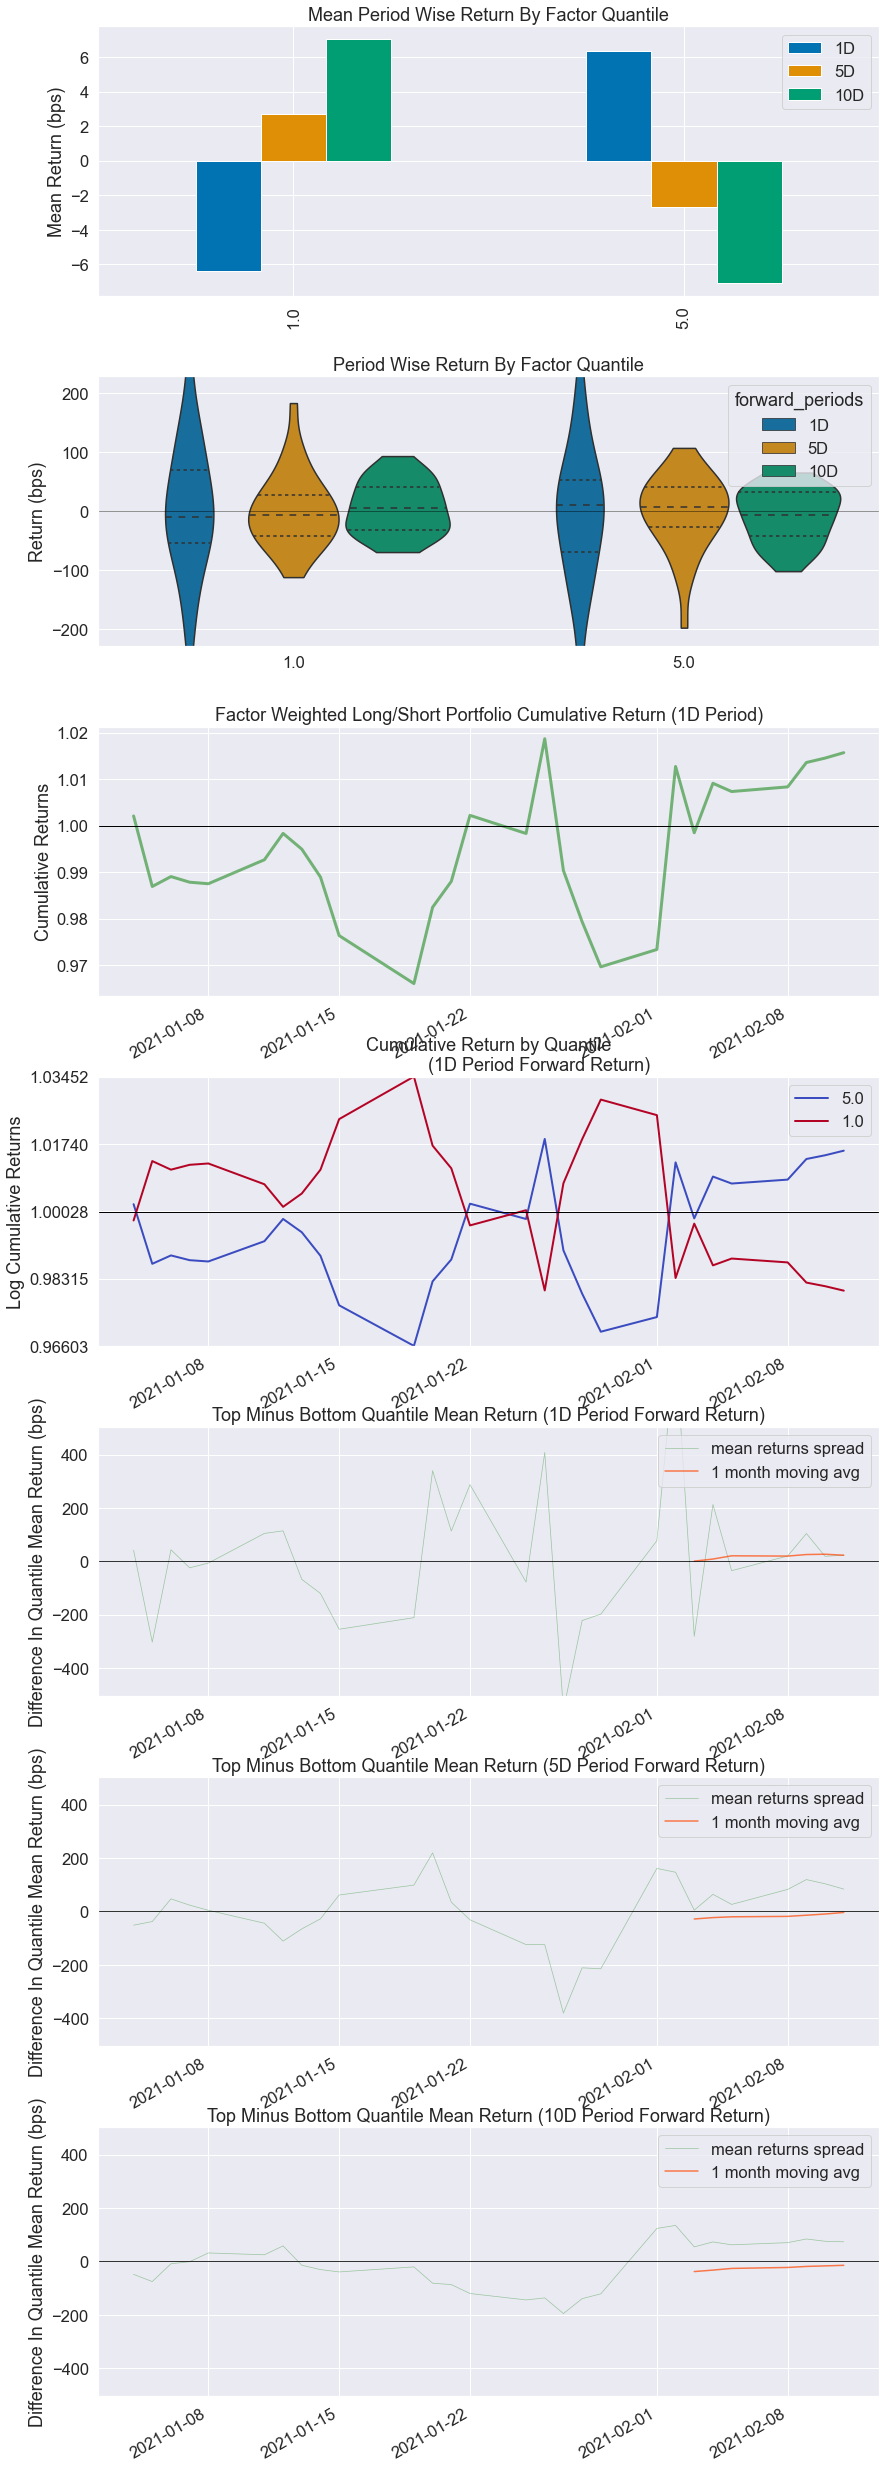

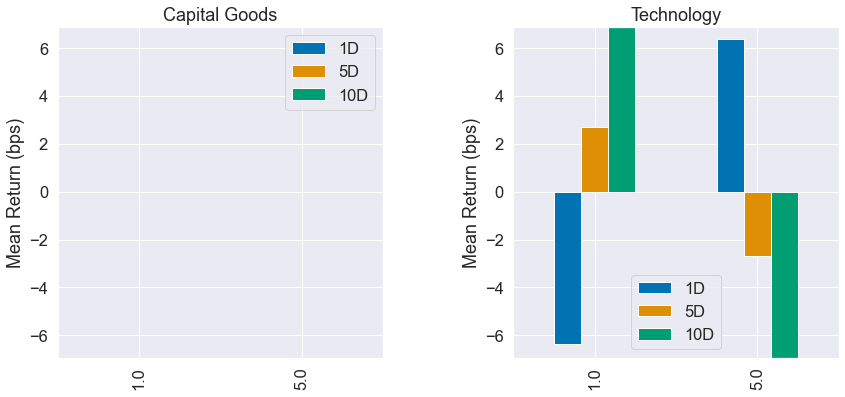

Information Analysis


,1D,5D,10D
IC Mean,0.071,0.143,-0.143
IC Std.,1.016,1.008,1.008
Risk-Adjusted IC,0.070,0.142,-0.142
t-stat(IC),0.372,0.750,-0.750
p-value(IC),0.713,0.460,0.460
IC Skew,-0.143,-0.289,0.289
IC Kurtosis,-1.979,-1.917,-1.917


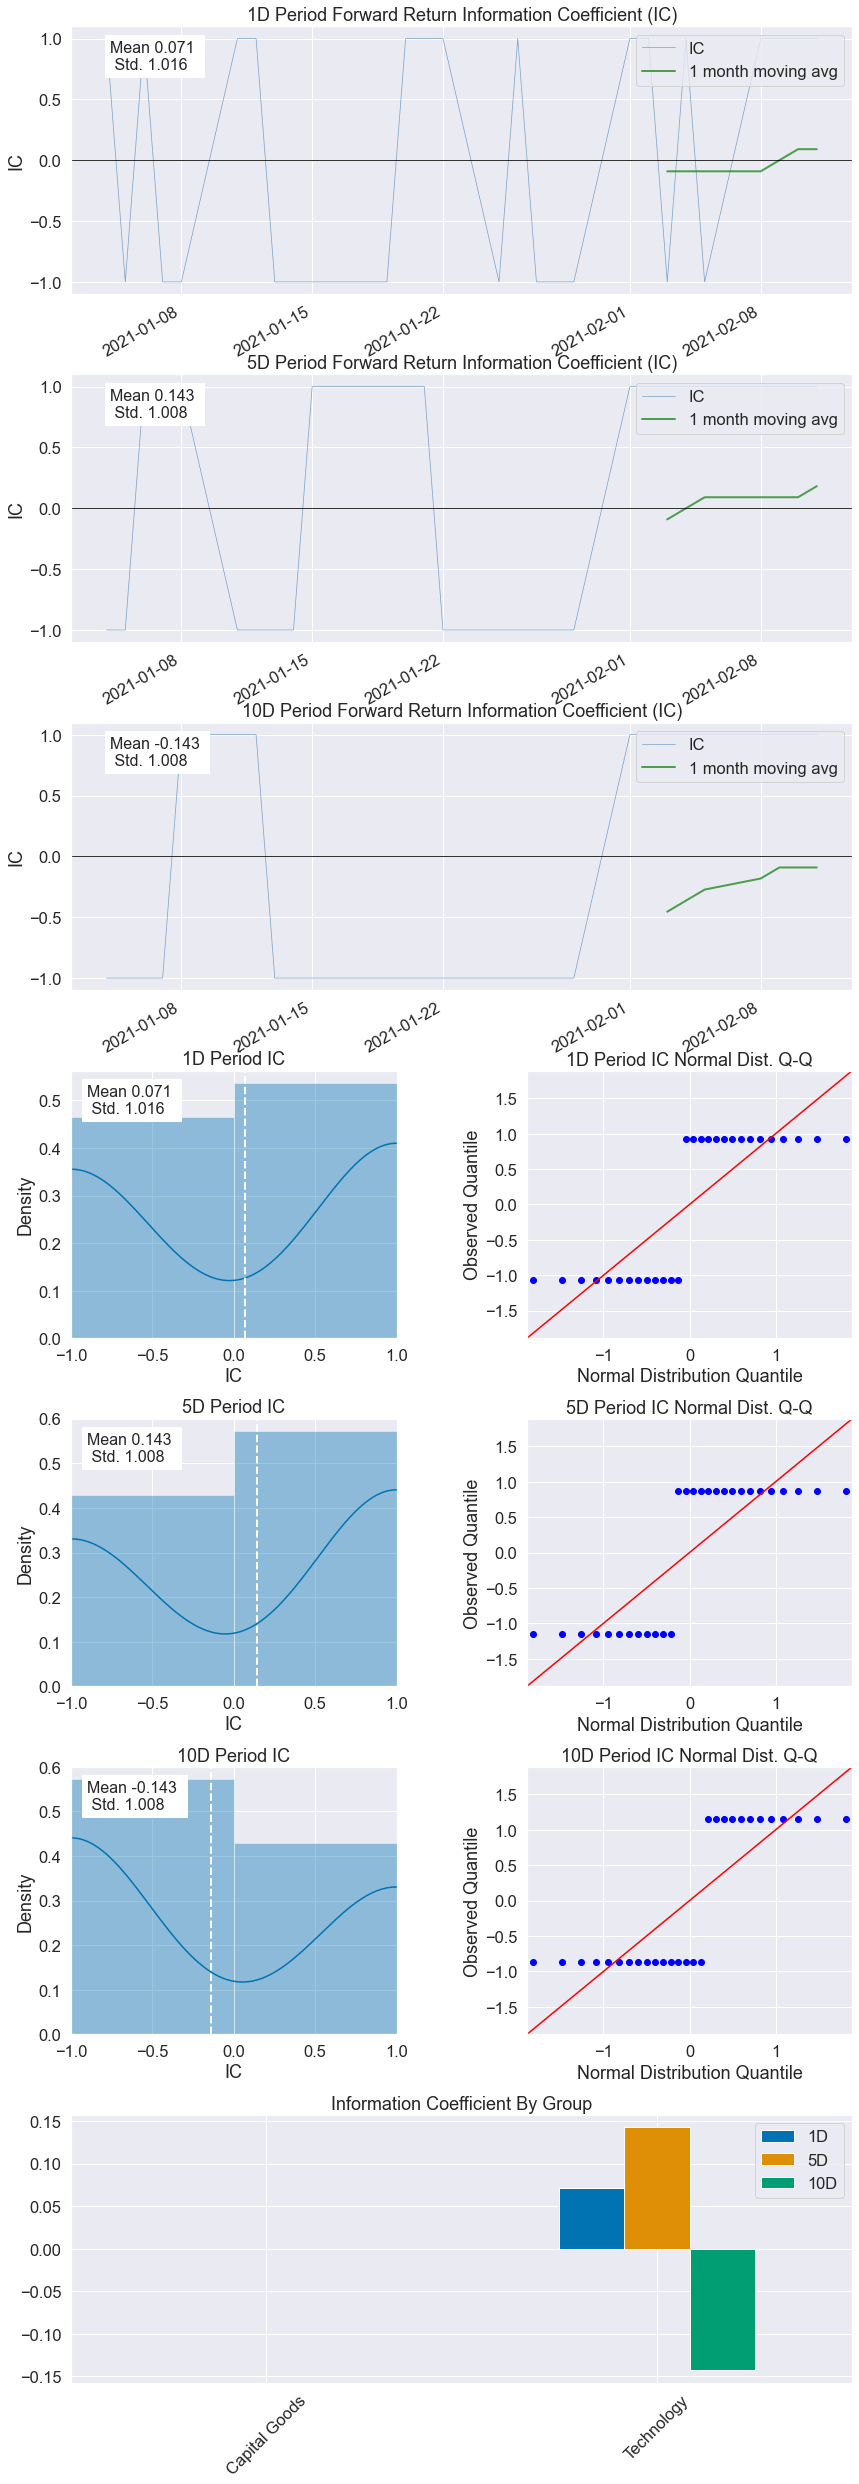

Turnover Analysis


,1D,5D,10D
Quantile 1.0 Mean Turnover,0.037,0.217,0.5
Quantile 5.0 Mean Turnover,0.037,0.217,0.5


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.926,0.565,-0.0


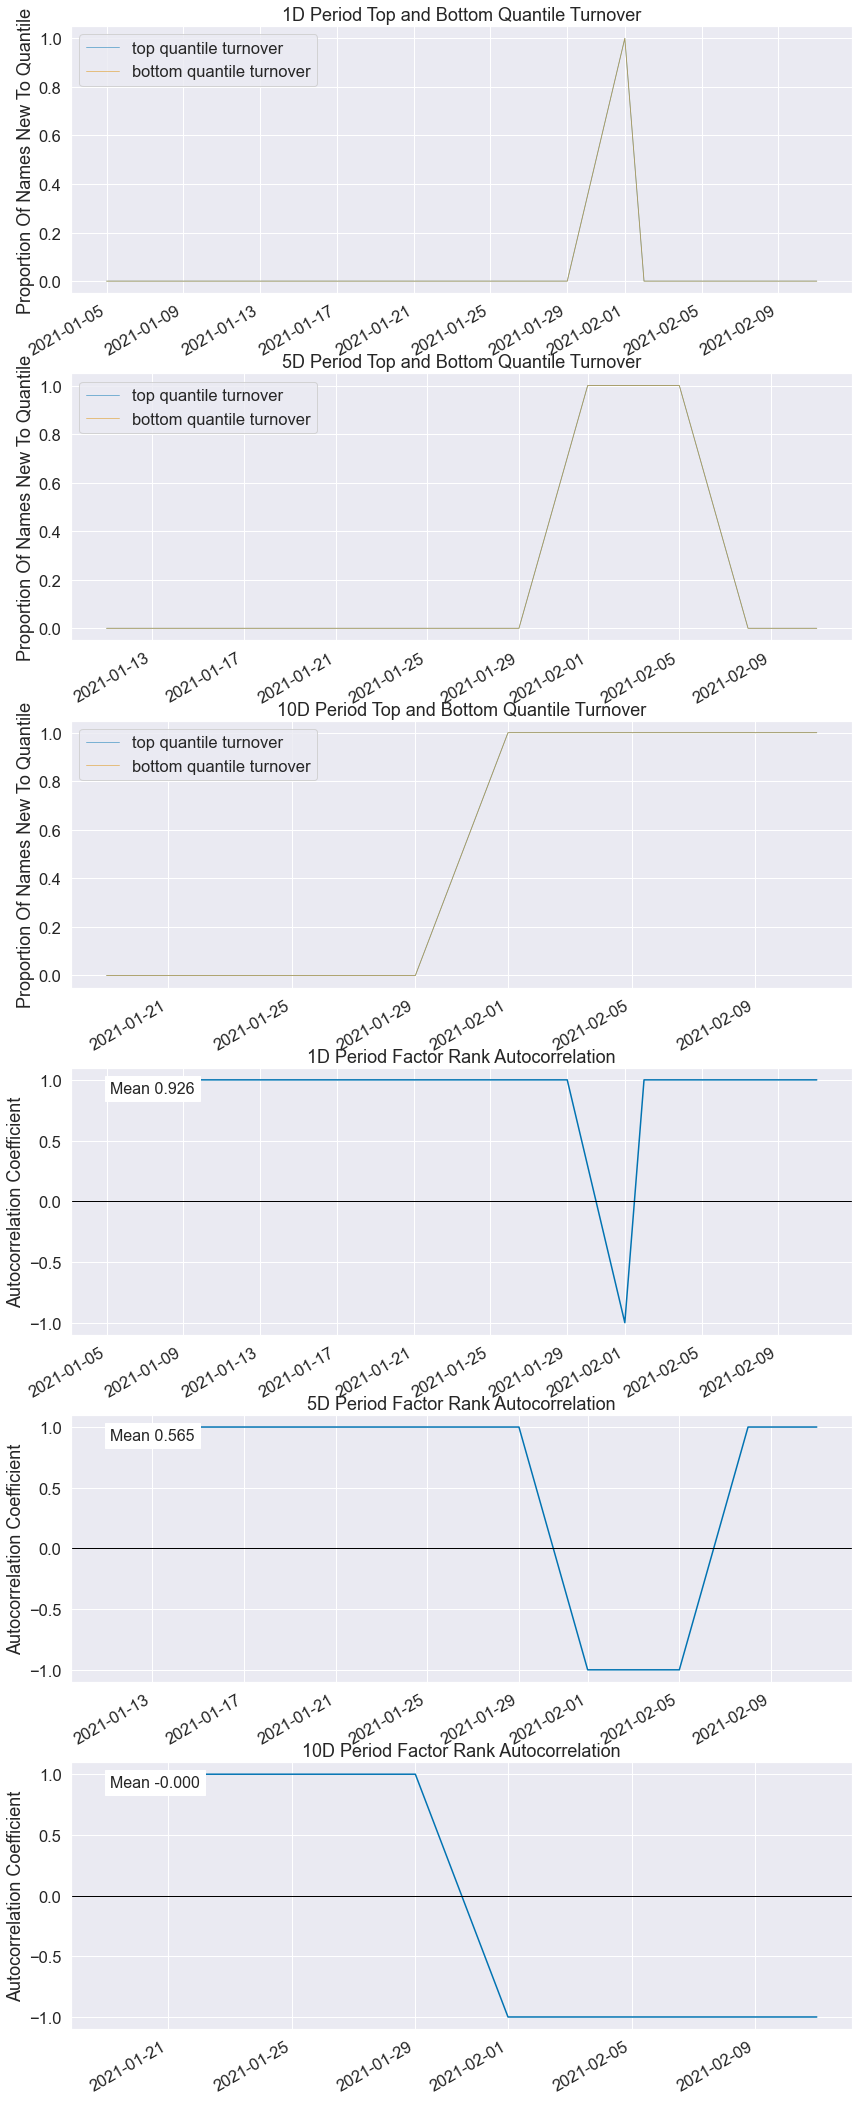

In [41]:
al.tears.create_full_tear_sheet(factor_data, long_short=True, group_neutral=False, by_group=True)

In [46]:
pf_returns, pf_positions, pf_benchmark = \
    al.performance.create_pyfolio_input(factor_data,
                                        period='1D',
                                        capital=100000,
                                        long_short=True,
                                        group_neutral=False,
                                        equal_weight=True,
                                        quantiles=[1,5],
                                        groups=None,
                                        benchmark_period='1D')

In [48]:
import pyfolio as pf

In [49]:
pf.tears.create_full_tear_sheet(pf_returns,
                                positions=pf_positions,
                                benchmark_rets=pf_benchmark,
                                hide_positions=True)

Start date,2021-01-04
End date,2021-02-11
Total months,1
,Backtest
Annual return,9.1%
Cumulative returns,1.4%
Annual volatility,17.4%
Sharpe ratio,0.59
Calmar ratio,1.89
Stability,0.17
Max drawdown,-4.8%


IndexError: index -1 is out of bounds for axis 0 with size 0